In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import  seaborn as sns
import sklearn

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor,RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score, mean_absolute_error , mean_squared_error
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [3]:
# Load the Dataset
# Using engine='python' and sep=None to let pandas detect the delimiter automatically
data = pd.read_csv("data_featured.csv", sep=None, engine='python')

In [4]:
"""
[ YouTube API ]  --->  [ dataset_copy.csv ]
                             |
                             V
                    [ Thumbnail Script ] ---> [ dataset_thumbnail_featured.csv ]
                             |
                             V
                    [ Feature Engineering ] (Merge & Clean & Featuring)
                             |
                             V
                    [ data_featured.csv ]
                             |
                             V
                    [ ML Models ]

This is the roadmap of project and python files.
"""

'\n[ YouTube API ]  --->  [ dataset_copy.csv ]\n                             |\n                             V\n                    [ Thumbnail Script ] ---> [ dataset_thumbnail_featured.csv ]\n                             |\n                             V\n                    [ Feature Engineering ] (Merge & Clean & Featuring)\n                             |\n                             V\n                    [ data_featured.csv ]\n                             |\n                             V\n                    [ ML Models (XGBoost) ]\n\nThis is the roadmap of project and python files.\n'

In [5]:
# Feature Selection
# Drop identifiers and raw text columns
drop_cols = ['video_title', 'upload_date', 'thumbnail_url', 'desc', 'tags',
             'video_id', 'thumb_hex', 'views']

In [6]:
X = data.drop(columns=drop_cols)
y = np.log1p(data['views']) # Normalize the target variable with log transformation

In [7]:
#Categorical Encoding
categorical_cols = ['is_shorts', 'category', 'default_language',
                    'has_manuel_subtitle', 'is_weekend', 'publish_day_of_week']

In [8]:
# Converting categories to numerical format using Ordinal Encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols].astype(str))

In [9]:
#Model Configuration (HistGradientBoostingRegressor)
# Identify indices of categorical features for optimized processing
cat_idx = [X.columns.get_loc(col) for col in categorical_cols]

In [10]:
#List Feature Columns
for col in X.columns:
    print(col)

duration_sec
is_shorts
category
follower_count
default_language
has_manuel_subtitle
thumb_hue
thumb_saturation
thumb_brightness
thumb_r
thumb_g
thumb_b
thumb_perceived_brightness
days_since_upload
upload_month
upload_year
publish_hour
publish_day_of_week
is_weekend
time_part_Afternoon
time_part_LateNight
time_part_Morning
time_part_Night
time_part_PrimeTime
title_length
title_word_count
title_uppercase_count
has_special_char
title_complexity
shout_factor
tag_count
desc_length
link_count
social_media_count
title_sentiment
reach_potential
follower_log
visual_pop
color_variety


In [11]:
#Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initializing the HistGradientBoostingRegressor with specific hyperparameter
model = HistGradientBoostingRegressor(
    categorical_features=cat_idx,
    max_iter=1500,           # High number of iterations with early stopping
    learning_rate=0.04,      # Balanced learning rate for stability
    max_depth=15,            # Depth to capture complex non-linear relationships
    max_leaf_nodes=127,      # Higher capacity for identifying viral patterns
    min_samples_leaf=15,     # To avoid over-splitting on small samples
    l2_regularization=0.8,   # Preventing overfitting
    early_stopping=True,
    random_state=42
)

In [13]:
model.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.04
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",1500
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",127
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",15
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",15
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.8
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged::

In [14]:
# Making predictions and calculating performance metrics (R2, MSE, MAE)
preds_log = model.predict(X_test)
gradient_r2 = r2_score(y_test, preds_log)
mse_gradient = mean_squared_error(y_test, preds_log)
mae_gradient = mean_absolute_error(y_test, preds_log)
print(f"HGBR Results -> MSE: {mse_gradient:.4f}, R2: {gradient_r2:.4f}, MAE: {mae_gradient:.4f}")

HGBR Results -> MSE: 2.6543, R2: 0.8849, MAE: 1.2010


In [15]:
# Standardizing features for linear models (Linear, Ridge, Lasso)
scaler = StandardScaler()
scaler.set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
#Linear Regression
regression = LinearRegression()
linear_regression = regression.fit(X_train_scaled, y_train)
y_pred_linear = linear_regression.predict(X_test_scaled)

In [17]:
# Evaluating Linear Regression performance
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print(f"Linear Regression Results -> MSE: {mse_linear:.4f}, R2: {r2_linear:.4f}, MAE: {mae_linear:.4f}")


Linear Regression Results -> MSE: 4.7817, R2: 0.7927, MAE: 1.6698


In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [ ]:
# Resetting split and scaling to ensure clean data for Ridge/Lasso
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler.set_output(transform="pandas")  


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Ridge Regression with Hyperparameter Tuning
ridge_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = GridSearchCV(Ridge(), ridge_grid, cv=5, scoring='r2')
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

In [21]:
# Evaluating Ridge performance
ridge_r2 = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print("MSE = ", mse_ridge)
print("R2 = ", ridge_r2)
print("MAE = ", mae_ridge)

MSE =  4.788604141442851
R2 =  0.7923826379154997
MAE =  1.670802637467552


In [22]:
from sklearn.linear_model import Lasso

In [23]:
# Lasso Regression (GridSearch) ---
lasso_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso = GridSearchCV(Lasso(), lasso_grid, cv=5, scoring='r2')
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

In [24]:
# Evaluating Lasso performance
lasso_r2 = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print("MSE = ", mse_lasso)
print("R2 = ", lasso_r2)
print("MAE = ", mae_lasso)

MSE =  4.797287911862302
R2 =  0.7920061395760711
MAE =  1.674900461214677


In [25]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

In [26]:
#Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [27]:
# Evaluating Decision Tree performance
dt_r2 = r2_score(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
print("MSE = ", mse_dt)
print("R2 = ", dt_r2)
print("MAE = ", mae_dt)

MSE =  4.227707636649604
R2 =  0.8167011761132514
MAE =  1.3914938882197718


In [28]:
# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xg = xgb_model.predict(X_test)

In [29]:
# Evaluating XGBoost performance
xg_r2 = r2_score(y_test, y_pred_xg)
mse_xg = mean_squared_error(y_test, y_pred_xg)
mae_xg = mean_absolute_error(y_test, y_pred_xg)
print("MSE = ", mse_xg)
print("R2 = ", xg_r2)
print("MAE = ", mae_xg)

MSE =  2.6973994192404853
R2 =  0.8830500631563519
MAE =  1.197652534783458


In [30]:
# Random Forest Regressor
Rtr_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
Rtr_model.fit(X_train, y_train)
y_pred_rtr = Rtr_model.predict(X_test)

In [31]:
# Evaluating Random Forest performance
rtr_r2 = r2_score(y_test, y_pred_rtr)
mse_rtr = mean_squared_error(y_test, y_pred_rtr)
mae_rtr = mean_absolute_error(y_test, y_pred_rtr)
print("MSE = ", mse_rtr)
print("R2 = ", rtr_r2)
print("MAE = ", mae_rtr)

MSE =  2.8060988870207972
R2 =  0.878337229083219
MAE =  1.2151965252433798


In [32]:
# Model Comparison Preparation
models = ['Linear', 'Ridge', 'HistGradient', 'Lasso', 'Decision Tree', 'XGBoost', 'RandomForest']
r2_list = [r2_linear, ridge_r2, gradient_r2, lasso_r2, dt_r2, xg_r2, rtr_r2]
mae_list = [mae_linear, mae_ridge, mae_gradient, mae_lasso, mae_dt, mae_xg, mae_rtr]
mse_list = [mse_linear, mse_ridge, mse_gradient, mse_lasso, mse_dt, mse_xg, mse_rtr]
colors = ['skyblue', 'steelblue', 'lightcoral', 'seagreen', 'orange', 'plum', 'gold']

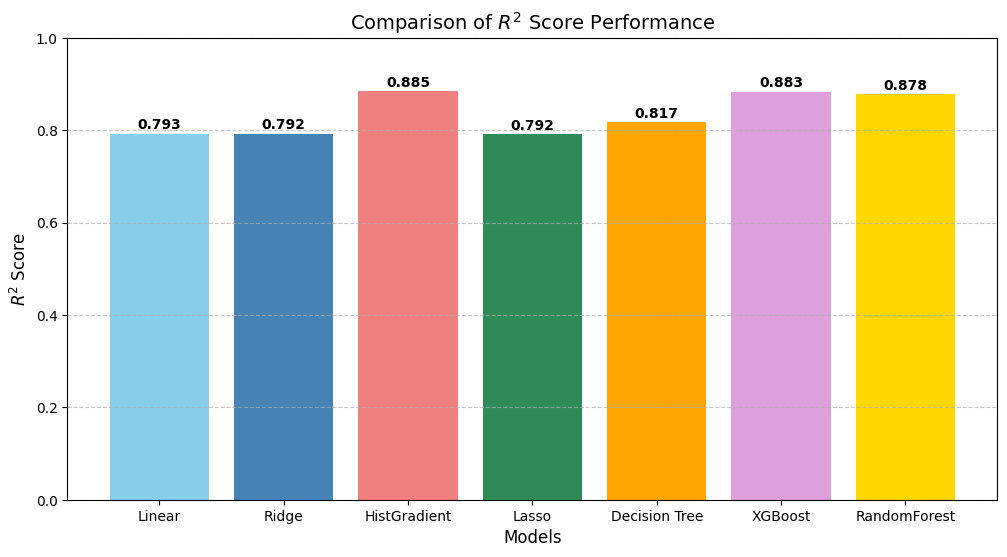

In [33]:
# Visualizing R2 Scores
plt.figure(figsize=(12, 6))
bars_r2 = plt.bar(models, r2_list, color=colors)
plt.xlabel('Models', fontsize=12)
plt.ylabel('$R^2$ Score', fontsize=12)
plt.title('Comparison of $R^2$ Score Performance', fontsize=14)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars_r2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{round(bar.get_height(), 3)}', ha='center', fontweight='bold')
plt.show()

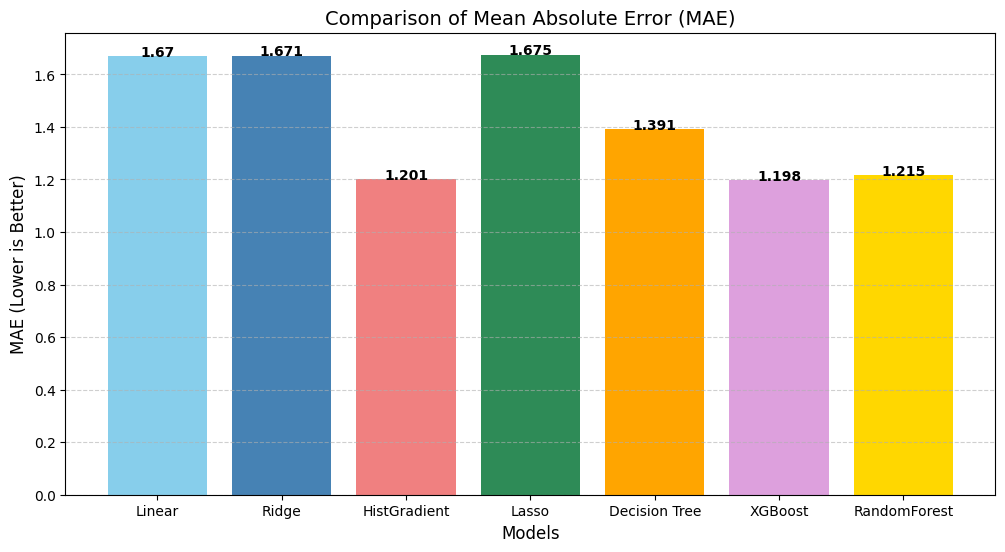

In [34]:
# Visualizing Mean Absolute Error (MAE)
plt.figure(figsize=(12, 6))
bars_mae = plt.bar(models, mae_list, color=colors)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAE (Lower is Better)', fontsize=12)
plt.title('Comparison of Mean Absolute Error (MAE)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars_mae:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{round(bar.get_height(), 3)}', ha='center', fontweight='bold')
plt.show()

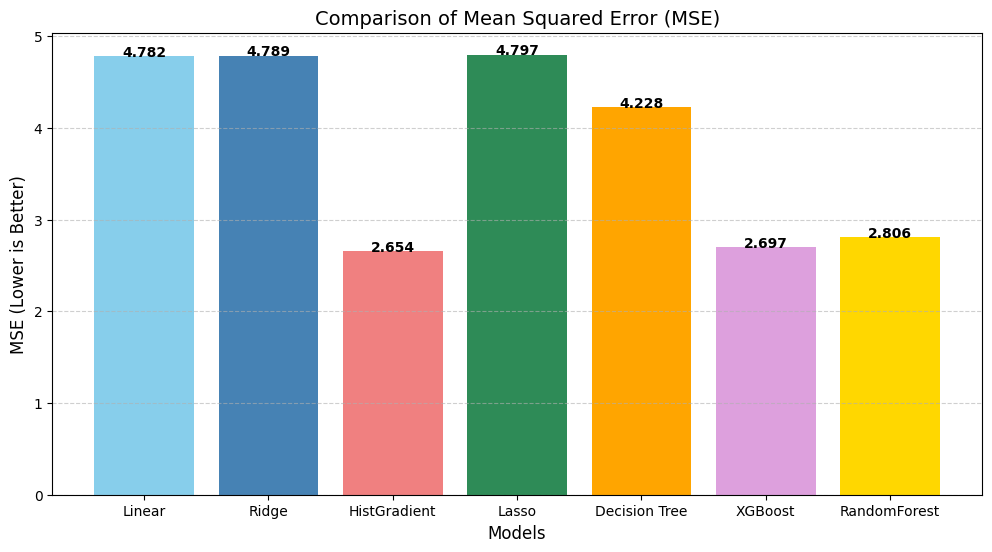

In [35]:
#Visualizing Mean Squared Error (MSE)
plt.figure(figsize=(12, 6))
bars_mse = plt.bar(models, mse_list, color=colors)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MSE (Lower is Better)', fontsize=12)
plt.title('Comparison of Mean Squared Error (MSE)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars_mse:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{round(bar.get_height(), 3)}', ha='center', fontweight='bold')
plt.show()